In [ ]:
# %%
import os
from pathlib import Path
import sys
sys.path.insert(0, str(Path(os.getcwd()).parent))

# Remove warnings
import warnings
warnings.filterwarnings('ignore')


In [ ]:

# %%
import logging
from financerag.retrieval import BM25Retriever, BM25Processor
import financerag.tasks as tasks_module
logging.getLogger("httpx").setLevel(logging.WARNING)  
from concurrent.futures import ThreadPoolExecutor, as_completed  

import importlib
import inspect
import os
import json
import pandas as pd
from datasets import load_dataset

from nltk.tokenize import word_tokenize, TweetTokenizer
from rank_bm25 import BM25Okapi
import nltk

import os
import pdb
import re
import shutil
import json
from pathlib import Path
# from dotenv import load_dotenv
from financerag.rerank import CrossEncoderReranker
from sentence_transformers import CrossEncoder
from financerag.retrieval import DenseRetrieval, SentenceTransformerEncoder

tweet_tokenizer = TweetTokenizer()
logging.basicConfig(level=logging.INFO)


In [ ]:

# %%
import logging
from financerag.retrieval import BM25Retriever, BM25Processor
import financerag.tasks as tasks_module

import importlib
import inspect
import os
import json
import pandas as pd
from datasets import load_dataset

from nltk.tokenize import word_tokenize, TweetTokenizer
from rank_bm25 import BM25Okapi
import nltk

tweet_tokenizer = TweetTokenizer()
logging.basicConfig(level=logging.INFO)

# %%
from typing import Any, Callable, Dict, List, Literal, Optional

def tokenize_list_tweet(input_list: List[str]) -> List[List[str]]:
    """
    Tokenizes a list of strings using the `nltk.word_tokenize` function.

    Args:
        input_list (`List[str]`):
            A list of input strings to be tokenized.

    Returns:
        `List[List[str]]`:
            A list where each element is a list of tokens corresponding to an input string.
    """
    return list(map(tweet_tokenizer.tokenize, input_list))


def clean_text(text):
    """
    Replace all Unicode escape sequences (e.g., \u2019, \u0080) with a space.
    """
    return re.sub(r"(\\u[0-9A-Fa-f]{4})+", " ", text)


def load_jsonl(file_path):
    """
    Load a JSONL file and return its content as a list of dictionaries.
    """
    if not file_path.exists():
        raise FileNotFoundError(f"File not found at {file_path}")
    with open(file_path, "r", encoding="utf-8") as f:
        return [json.loads(clean_text(line.strip())) for line in f]




In [ ]:


# %%
def combine_texts(group):  
    combined_text = []  
    title = '\n\n\n'+group['title'].iloc[0]  
    for text in group['corpus_text']:  
        combined_text.append(title)  
        combined_text.append(text)  
    return ' '.join(combined_text)  
  
def generate_answer(query_text, corpus_text):  
    prompt = f"Context: {corpus_text}\n\nQuestion: {query_text}\n\nAnswer:"  
    response = oai_client.chat.completions.create(
                        model='gpt-4o-mini',
                        messages=[
                            {
                                "role": "system",
                                "content": "You are an investor trying to answer the query based on the provided context. Try to answer the query as best as you can provided the given context.",
                            },
                            {
                                "role": "user",
                                "content": [
                                    {"type": "text", "text": prompt},
                                ],
                            },
                        ],
                        temperature=0.0,
                        max_tokens=800,
                        top_p=0.95,
                        frequency_penalty=0,
                        presence_penalty=0,
                        stop=None,
                    )
    answer = response.choices[0].message.content.strip()  

    return answer  
  


In [ ]:

# %%
task_list = ['FinQABench', 'FinDER',  'FinanceBench', 'TATQA', 'FinQA', 'ConvFinQA', 'MultiHiertt']
dataset_dir = '../data'

corpus_file = ''
query_file = ''


In [ ]:

# %%
def generate_true_answer(task_class, overwrite=False):

    if os.path.exists(f'{dataset_dir}/{task_class.lower()}_generated_answers.csv') and not overwrite:
        print(f"True answers for {task_class} already exist. Skipping...")
        return
    
    actual_doc = pd.read_csv(f'{dataset_dir}/{task_class.split("_")[0]}_qrels.tsv', sep='\t')



    query_file_name = 'queries'
    if query_file != '':
        query_file_name += '_'+query_file

    queries = load_jsonl(Path(f"{dataset_dir}/{task_class.lower()}_queries/{query_file_name}.jsonl"))
    queries = pd.DataFrame(queries)
    queries.rename(columns={'_id' : 'query_id', 'text': 'query_text'}, inplace=True)
    queries['query_text'] = queries['title'] + ' ' + queries['query_text']
    queries.drop(columns=['title'], inplace=True)

    corpus_file_name = 'corpus'
    if corpus_file != '':
        corpus_file_name += '_'+corpus_file

    corpus = load_jsonl(Path(f"{dataset_dir}/{task_class.lower()}_corpus/{corpus_file_name}.jsonl"))
    corpus = pd.DataFrame(corpus)
    corpus.rename(columns={'_id' : 'corpus_id', 'text': 'corpus_text'}, inplace=True)
    actual_doc = pd.merge(actual_doc, corpus, on='corpus_id', how='left')
    combined_doc = actual_doc.groupby('query_id').apply(combine_texts).reset_index()  
    combined_doc.columns = ['query_id', 'corpus_text']  
    combined_doc = pd.merge(combined_doc, queries, on='query_id', how='left')
    combined_doc.dropna(inplace=True)
    print(f"Generating true answers for {task_class}... Length of combined_doc: {len(combined_doc)}")

    # Parallelize the answer generation  
    def parallel_generate_answer(row):  
        return generate_answer(row['query_text'], row['corpus_text'])  
  
    with ThreadPoolExecutor(max_workers=10) as executor:  
        futures = {executor.submit(parallel_generate_answer, row): index for index, row in combined_doc.iterrows()}  
        for future in as_completed(futures):  
            index = futures[future]  
            try:  
                combined_doc.at[index, 'generated_answer'] = future.result()  
            except Exception as e:  
                print(f"Error generating answer for row {index}: {e}")  
                
    # combined_doc['generated_answer'] = combined_doc.apply(lambda row: generate_answer(row['query_text'], row['corpus_text']), axis=1)  
    
    combined_doc.to_csv(f'{dataset_dir}/{task_class}_generated_answers.csv', index=False)


In [ ]:

# %%
def generate_estimated_answer(task_class, model_name, overwrite=False, output_dir='../results', query_file='', corpus_file=''):

    if os.path.exists(f'{output_dir}/{model_name}/{task_class}_estimated_answers.csv') and not overwrite:
        print(f"True answers for {task_class} already exist. Skipping...")
        return
    
    actual_doc = pd.read_csv(f'{dataset_dir}/{task_class.split("_")[0]}_qrels.tsv', sep='\t')

    file_name = f"{output_dir}/{model_name}/{task_class}.json"
    with open(file_name, "r") as json_file:
        retrieval_result = json.load(json_file)
    query_ids = []  
    corpus_ids = []  
    scores = []  
    
    # Iterate through the dictionary  
    for query_id, corpus_dict in retrieval_result.items():  
        for corpus_id, score in corpus_dict.items():  
            query_ids.append(query_id)  
            corpus_ids.append(corpus_id)  
            scores.append(score)  
    
    # Create DataFrame  
    df = pd.DataFrame({  
        'query_id': query_ids,  
        'corpus_id': corpus_ids,  
        'score': scores  
    })  
    top_docs = df.groupby('query_id').apply(lambda x: x.nlargest(10, 'score')).reset_index(drop=True)  
    top_docs.drop(columns=['score'], inplace=True)
    top_docs = top_docs.loc[top_docs['query_id'].isin(actual_doc['query_id'])]
    query_file_name = 'queries'
    if query_file != '':
        query_file_name += '_'+query_file

    queries = load_jsonl(Path(f"{dataset_dir}/{task_class.lower()}_queries/{query_file_name}.jsonl"))
    queries = pd.DataFrame(queries)
    queries.rename(columns={'_id' : 'query_id', 'text': 'query_text'}, inplace=True)
    queries['query_text'] = queries['title'] + ' ' + queries['query_text']
    queries.drop(columns=['title'], inplace=True)

    corpus_file_name = 'corpus'
    if corpus_file != '':
        corpus_file_name += '_'+corpus_file

    corpus = load_jsonl(Path(f"{dataset_dir}/{task_class.lower()}_corpus/{corpus_file_name}.jsonl"))
    corpus = pd.DataFrame(corpus)
    corpus.rename(columns={'_id' : 'corpus_id', 'text': 'corpus_text'}, inplace=True)
    actual_doc = pd.merge(top_docs, corpus, on='corpus_id', how='left')
    combined_doc = actual_doc.groupby('query_id').apply(combine_texts).reset_index()  
    combined_doc.columns = ['query_id', 'corpus_text']  
    combined_doc = pd.merge(combined_doc, queries, on='query_id', how='left')
    combined_doc.dropna(inplace=True)
    print(f"Generating estimated answers for {task_class}... Length of combined_doc: {len(combined_doc)}")

    # Parallelize the answer generation  
    def parallel_generate_answer(row):  
        return generate_answer(row['query_text'], row['corpus_text'])  
  
    with ThreadPoolExecutor(max_workers=10) as executor:  
        futures = {executor.submit(parallel_generate_answer, row): index for index, row in combined_doc.iterrows()}  
        for future in as_completed(futures):  
            index = futures[future]  
            try:  
                combined_doc.at[index, 'generated_answer'] = future.result()  
            except Exception as e:  
                print(f"Error generating answer for row {index}: {e}")  
                
    # combined_doc['generated_answer'] = combined_doc.apply(lambda row: generate_answer(row['query_text'], row['corpus_text']), axis=1)  
    
    combined_doc.to_csv(f'{output_dir}/{model_name}/{task_class}_estimated_answers.csv', index=False)


In [ ]:

# %%
for task_class in task_list:
    generate_true_answer(task_class, overwrite=True)
    print(f"Generated true answers for {task_class}...")


In [ ]:

# %%
# model_name = 'hybrid'
model_name = 'hybrid_ms-marco-MiniLM-L-12-v2'

overwrite=True
output_dir='../results'
query_file=''
corpus_file=''


for task_class in task_list:
    generate_estimated_answer(task_class, model_name, overwrite, output_dir, query_file, corpus_file)
    print(f"Generated estimated answers for {task_class}...")


In [ ]:

# %%
import pandas as pd  
import torch  
from transformers import BertModel, BertTokenizer  
from sklearn.metrics.pairwise import cosine_similarity  


In [ ]:

# Function to get the BERT embeddings  


# %%
model_list = ['BM25', 'intfloat_e5-large-v2', 'hybrid', 'hybrid_ms-marco-MiniLM-L-12-v2']
for task_class in task_list:
    master_answer = pd.DataFrame()
    for model_ in model_list:
        true_answers = pd.read_csv(f'{dataset_dir}/{task_class}_generated_answers.csv')
        estimated_answers = pd.read_csv(f'{output_dir}/{model_}/{task_class}_estimated_answers.csv')

        answers_combined = pd.merge(true_answers, estimated_answers, on=['query_id'], how='left', suffixes=('_true', '_estimated'))


        # Load pre-trained BERT model and tokenizer  
        model_name = 'bert-base-uncased'  
        tokenizer = BertTokenizer.from_pretrained(model_name)  
        model = BertModel.from_pretrained(model_name)  

        def get_bert_embedding(text):  
            inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)  
            with torch.no_grad():  
                outputs = model(**inputs)  
            # Take the mean of the token embeddings  
            embeddings = outputs.last_hidden_state.mean(dim=1)  
            return embeddings  


        # Compute embeddings for generated and true answers  
        answers_combined['generated_embedding'] = answers_combined['generated_answer_true'].apply(get_bert_embedding)  
        answers_combined['true_embedding'] = answers_combined['generated_answer_estimated'].apply(get_bert_embedding)  

        # Compute cosine similarity between embeddings  
        def compute_similarity(row):  
            return cosine_similarity(row['generated_embedding'], row['true_embedding'])[0][0]  

        answers_combined['similarity_score'] = answers_combined.apply(compute_similarity, axis=1)  

        # Print the DataFrame with similarity scores  
        answers = answers_combined[['query_id', 'similarity_score']]
        answers.rename(columns={'similarity_score': f'{model_}_similarity_score'}, inplace=True)
    
        if master_answer.empty:
            master_answer = answers
        else:
            master_answer = pd.merge(master_answer, answers, on='query_id', how='left')
    master_answer.to_csv(f'{output_dir}/{task_class}_similarity', index=False)


In [7]:
output_dir = '../results'
model_list = ['BM25', 'intfloat_e5-large-v2', 'hybrid',]

# %%
for task_class in task_list:
    print(f"Results for {task_class}")
    master_answer = pd.read_csv(f'{output_dir}/{task_class}_similarity.csv')
    for model_ in model_list:
        print(f"Average similarity score for {model_}: {master_answer[f'{model_}_similarity_score'].mean()}")


Results for FinQABench
Average similarity score for BM25: 0.9522207683333335
Average similarity score for intfloat_e5-large-v2: 0.9575830106666668
Average similarity score for hybrid: 0.9561472166666667
Results for FinDER
Average similarity score for BM25: 0.8551808621875
Average similarity score for intfloat_e5-large-v2: 0.9189608984375
Average similarity score for hybrid: 0.92205786078125
Results for FinanceBench
Average similarity score for BM25: 0.8962711937777779
Average similarity score for intfloat_e5-large-v2: 0.9608198024444445
Average similarity score for hybrid: 0.9542490580000001
Results for TATQA
Average similarity score for BM25: 0.9122370212248996
Average similarity score for intfloat_e5-large-v2: 0.9256201163052209
Average similarity score for hybrid: 0.9308085936546185
Results for FinQA
Average similarity score for BM25: 0.9504176215697674
Average similarity score for intfloat_e5-large-v2: 0.9333765502034884
Average similarity score for hybrid: 0.9523092939825581
Resul

In [8]:

output_dir = '../results'
model_list = ['BM25', 'intfloat_e5-large-v2', 'hybrid']
summary_data = []

for task_class in task_list:
    master_answer = pd.read_csv(f'{output_dir}/{task_class}_similarity.csv')
    for model_ in model_list:
        avg_score = master_answer[f'{model_}_similarity_score'].mean()
        summary_data.append({'Task Class': task_class, 'Model': model_, 'Average Score': avg_score})

summary_df = pd.DataFrame(summary_data)
summary_df

,Task Class,Model,Average Score
0,FinQABench,BM25,0.952221
1,FinQABench,intfloat_e5-large-v2,0.957583
2,FinQABench,hybrid,0.956147
3,FinDER,BM25,0.855181
4,FinDER,intfloat_e5-large-v2,0.918961
5,FinDER,hybrid,0.922058
6,FinanceBench,BM25,0.896271
7,FinanceBench,intfloat_e5-large-v2,0.960820
8,FinanceBench,hybrid,0.954249
9,TATQA,BM25,0.912237


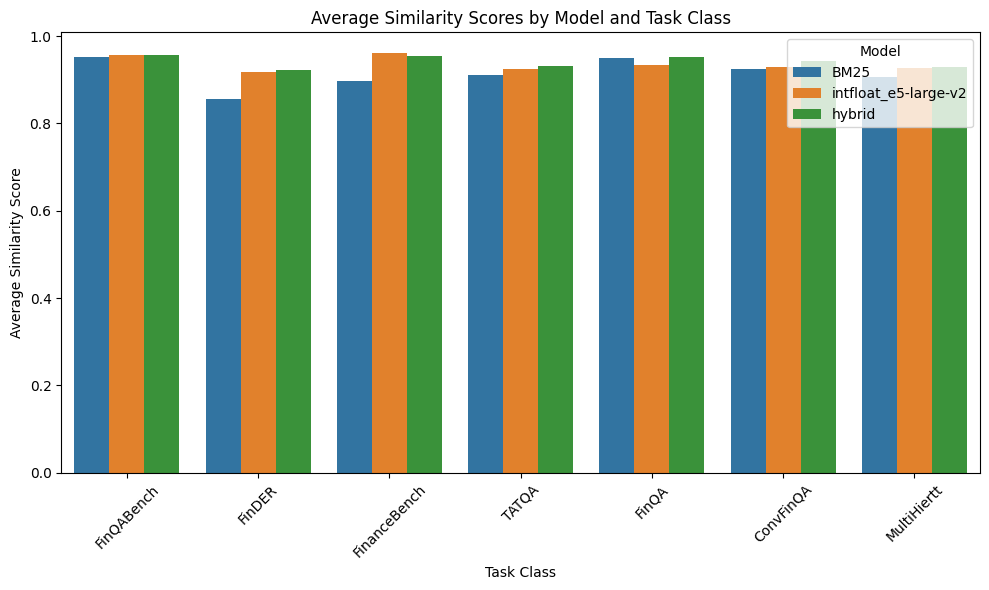

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the DataFrame from the tabular step to a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x='Task Class', y='Average Score', hue='Model')

# Add labels and title
plt.title('Average Similarity Scores by Model and Task Class')
plt.ylabel('Average Similarity Score')
plt.xlabel('Task Class')
plt.legend(title='Model')
plt.xticks(rotation=45)
plt.tight_layout()


# Show or save the plot
plt.savefig(f'{output_dir}/similarity_scores_plot.png')
plt.show()


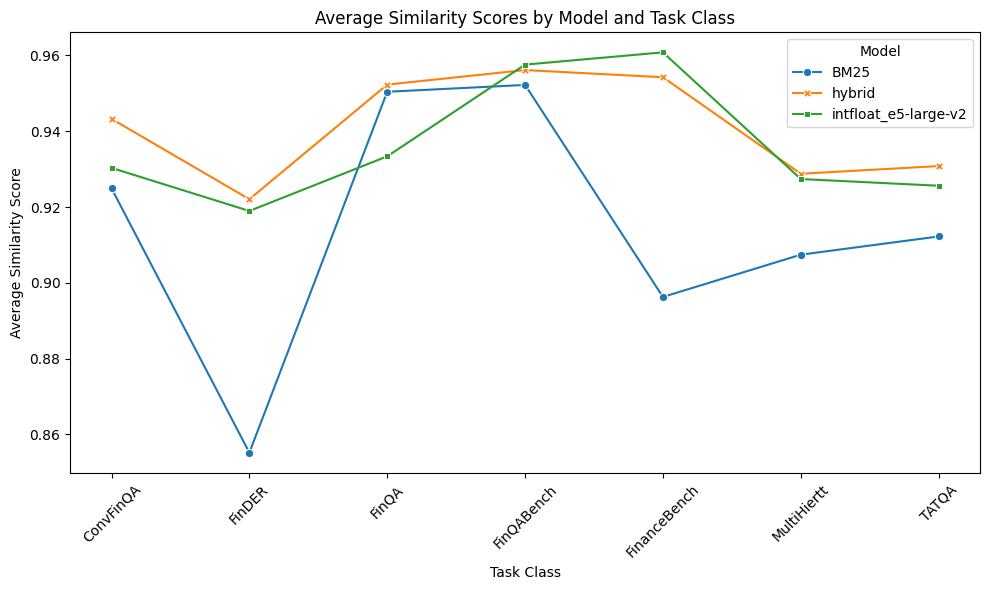

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the DataFrame for a line plot
pivot_df = summary_df.pivot(index='Task Class', columns='Model', values='Average Score')

plt.figure(figsize=(10, 6))
sns.lineplot(data=pivot_df, markers=True, dashes=False)

# Add labels and title
plt.title('Average Similarity Scores by Model and Task Class')
plt.ylabel('Average Similarity Score')
plt.xlabel('Task Class')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()

# Show the plot
plt.savefig(f'{output_dir}/line_plot_similarity_scores.png')
plt.show()


In [17]:
import pandas as pd

output_dir = '../results'
model_list = ['BM25', 'intfloat_e5-large-v2', 'hybrid']

# Prepare summary data
summary_data = []

for task_class in task_list:
    master_answer = pd.read_csv(f'{output_dir}/{task_class}_similarity.csv')
    row = {'Task Class': task_class}
    for model_ in model_list:
        row[model_] = master_answer[f'{model_}_similarity_score'].mean()
    summary_data.append(row)

# Create a DataFrame
summary_df = pd.DataFrame(summary_data)

# Highlight "hybrid" in a separate column
summary_df['Hybrid (Final Model)'] = summary_df['hybrid']

# Drop the original hybrid column for clarity
summary_df = summary_df[['Task Class', 'BM25', 'intfloat_e5-large-v2', 'Hybrid (Final Model)']]

# Save to CSV for better sharing
summary_df.to_csv(f'{output_dir}/highlighted_table_similarity.csv', index=False)

# Display the table
summary_df

,Task Class,BM25,intfloat_e5-large-v2,Hybrid (Final Model)
0,FinQABench,0.952221,0.957583,0.956147
1,FinDER,0.855181,0.918961,0.922058
2,FinanceBench,0.896271,0.960820,0.954249
3,TATQA,0.912237,0.925620,0.930809
4,FinQA,0.950418,0.933377,0.952309
5,ConvFinQA,0.924938,0.930326,0.943269
6,MultiHiertt,0.907424,0.927391,0.928780


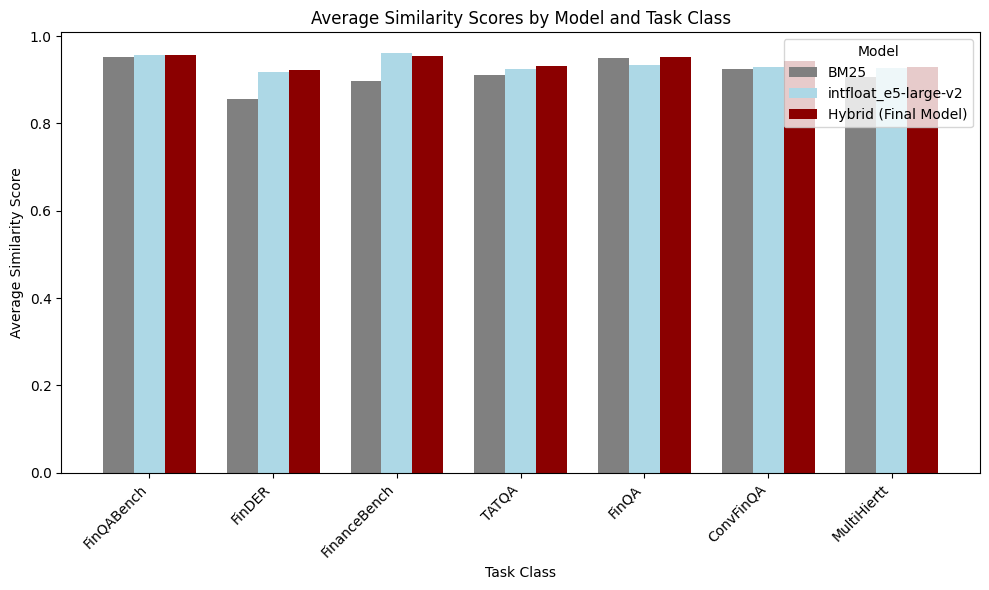

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Define task classes and models
task_classes = summary_df['Task Class']
models = ['BM25', 'intfloat_e5-large-v2', 'Hybrid (Final Model)']

# Extract scores
scores = summary_df[models].values
x = np.arange(len(task_classes))  # Task class indices

# Plot settings
width = 0.25  # Width of each bar
colors = ['gray', 'lightblue', 'darkred']  # Highlight "Hybrid (Final Model)" distinctly

plt.figure(figsize=(10, 6))

# Plot each model's scores
for i, model in enumerate(models):
    plt.bar(x + i * width, scores[:, i], width=width, label=model, color=colors[i])

# Add labels, title, and legend
plt.xticks(x + width, task_classes, rotation=45, ha='right')
plt.ylabel('Average Similarity Score')
plt.xlabel('Task Class')
plt.title('Average Similarity Scores by Model and Task Class')
plt.legend(title='Model')
plt.tight_layout()

# Save as a high-quality image for LaTeX
plt.savefig(f'{output_dir}/similarity_scores_latex_plot.pdf', format='pdf')
plt.savefig(f'{output_dir}/similarity_scores_latex_plot.png', dpi=300)

# Show the plot
plt.show()
